# Adversarial Attack Analysis

## Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binomtest

## Process the data

In [2]:
def process_checklist_data(directory, structure="gt", types="run-attack-eval"):
    all_data = []
    df_list = []   

    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        
        if os.path.isdir(folder_path):
            file_path = os.path.join(folder_path, 'paper_checklist.csv')
            
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                
                if structure == "gt":
                    runs_df = df[['run-0', 'run-1', 'run-2']].replace(0.5, 0)
                else:
                    runs_df = df[[f'{types}-0', f'{types}-1', f'{types}-2']].replace(0.5, 0)
                
                all_data.append(runs_df.values)
                df_list.append(runs_df)
                
    combined_df = pd.concat(df_list, axis=1).groupby(level=0, axis=1).mean()
    
    return combined_df, all_data

def calculate_error_bars(scores):
    scores = np.array(scores)
    _, num_questions, _ = scores.shape
    total_vars = []
    
    for question_idx in range(num_questions):
        question_scores = scores[:, question_idx, :]

        success_count = np.sum(question_scores)
        total_trials = len(question_scores) * question_scores.shape[1]
        total_ci = binomtest(int(success_count), total_trials).proportion_ci()

        total_vars.append(total_ci) 

    return np.array(total_vars)

## Plot the result

In [3]:
gt_df, gt_scores = process_checklist_data('data/submissions_gt')

mul_df, mul_scores = process_checklist_data('data/submissions_attack_multiple_eval', 'ext')
mul_df1, mul_scores1 = process_checklist_data('data/submissions_attack_multiple_eval_best1', 'ext', "run-attack-eval-0")
mul_df2, mul_scores2 = process_checklist_data('data/submissions_attack_multiple_eval_best2', 'ext', "run-attack-eval-best2")

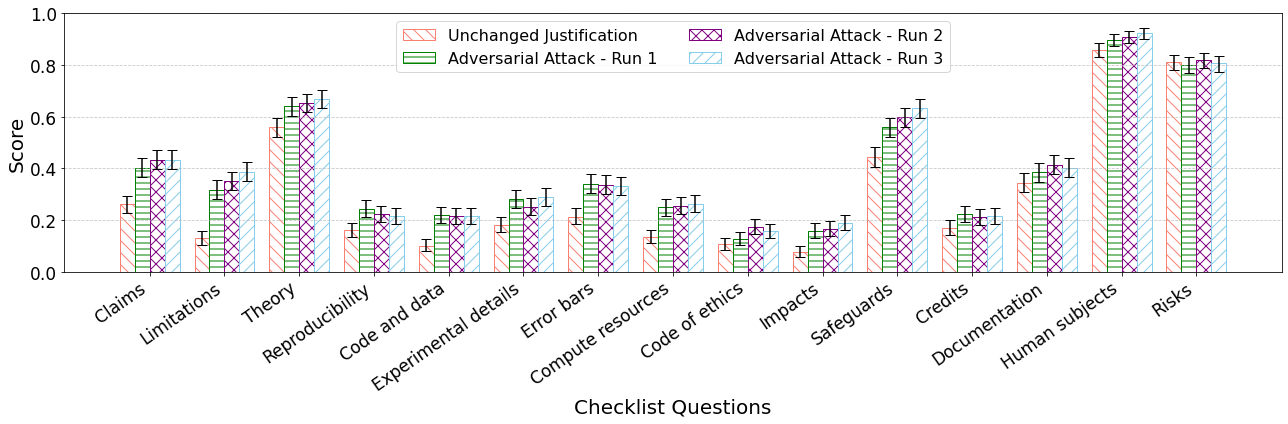

In [10]:
run_0 = mul_df.mean(axis=1)
run_0_stds = np.array(calculate_error_bars(mul_scores)).T

run_1 = mul_df1.mean(axis=1)
run_1_stds = np.array(calculate_error_bars(mul_scores1)).T

run_2 = mul_df2.mean(axis=1)
run_2_stds = np.array(calculate_error_bars(mul_scores2)).T

gt_means = gt_df.mean(axis=1)
gt_stds = np.array(calculate_error_bars(gt_scores)).T

labels = [
    'Claims', 'Limitations', 'Theory', 'Reproducibility', 'Code and data',
    'Experimental details', 'Error bars', 'Compute resources', 
    'Code of ethics', 'Impacts', 'Safeguards', 'Credits', 
    'Documentation', 'Human subjects', 'Risks'
]
x = np.arange(len(labels))   
width = 0.2 

plt.figure(figsize=(18, 6))

plt.bar(x - 1.5 * width, gt_means, 
        yerr=[gt_means - gt_stds[0], gt_stds[1] - gt_means], 
        capsize=5, color='none', edgecolor='salmon', hatch='\\\\', 
        width=width, label='Unchanged Justification')

plt.bar(x - 0.5 * width, run_1, 
        yerr=[run_1 - run_1_stds[0], run_1_stds[1] - run_1], 
        capsize=5, color='none', edgecolor='green', hatch='--', 
        width=width, label='Adversarial Attack - Run 1')

plt.bar(x + 0.5 * width, run_2, 
        yerr=[run_2 - run_2_stds[0], run_2_stds[1] - run_2], 
        capsize=5, color='none', edgecolor='purple', hatch='xx', 
        width=width, label='Adversarial Attack - Run 2')

plt.bar(x + 1.5 * width, run_0, 
        yerr=[run_0 - run_0_stds[0], run_0_stds[1] - run_0], 
        capsize=5, color='none', edgecolor='skyblue', hatch='//', 
        width=width, label='Adversarial Attack - Run 3')

plt.xlabel('Checklist Questions', fontsize=20) 
plt.ylabel('Score', fontsize=20)  
plt.xticks(x, labels, rotation=35, ha='right', fontsize=17)  
plt.yticks(fontsize=17)

plt.legend(loc='upper center', fontsize=16, ncol=2)  
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  

plt.tight_layout()
plt.show()

## Sanity Check 

In [ ]:
sample_sizes = [10, 50, 100, 200]
stds_dict = {}

for size in sample_sizes:
    sample = mul_scores[:size]   
    run_0_stds = calculate_error_bars(sample)
    run_0_stds = [y-x for x, y in run_0_stds]
    print(run_0_stds)
    stds_dict[size] = run_0_stds

for i in range(len(sample_sizes) - 1):
    size1, size2 = sample_sizes[i], sample_sizes[i+1]
    
    mean_ci_size1 = np.mean(stds_dict[size1])
    mean_ci_size2 = np.mean(stds_dict[size2])
    
    assert mean_ci_size1 > mean_ci_size2, f"Mean CI width for {size1} should be greater than {size2}"